## **Training the Machine Learning models**
----

## **1 - Applying machine learning algorithms to molecular dynamics trajectories**

We will train a random forest model, a logistic regression model, and a Multilayer
Perceptron (MLP) model using the data obtained from our molecular dynamics (MD)
trajectories, following methods similar to those outlined in our introductory machine learning
tutorial. After training these models, we will obtain a dataframe containing information
about the most critical residue pairs in determining the differences between SARS-CoV-1
and SARS-CoV-2.

# 1.1 **Background and outline of methodologies**

A novel coronavirus, severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2), has spread throughout
the world. SARS-CoV-2 is less deadly but more transmissible than SARS-CoV, which appeared in late 2002.
Both viruses first engage with their host by binding to the same target protein, ACE2, via the receptor
binding domain (RBD). Herein, we will use molecular dynamics (MD) simulations and machine learning
(ML) to elucidate the differences in binding between the two viruses.

💻🔬🦠 Molecular Dynamics is a powerful simulation technique used to study the physical movements of atoms and molecules. It is known as the "computational microscope into the cell." 

By providing a detailed picture of how atoms interact over time, MD is a fundamental tool in understanding the behavior of complex systems at the molecular level. First, a model a system is built, such as atoms in a protein, and then solving Newton's equations of motion for all the particles in the system. In essence, this technique calculates the positions, velocities, and accelerations of atoms as they evolve over time under the influence of physical forces. 

📈🕒 These calculations are carried out over extremely small time intervals, often on the order of femtoseconds to capture the rapid changes in atomic configurations. 

🌊 The output is a trajectory of the dynamics of your system of interest. These simulations provide a window into the atomic-level dance of matter, bridging the gap between theory and real-world behavior. It is a vital tool for scientists seeking to understand and predict the properties of molecular systems

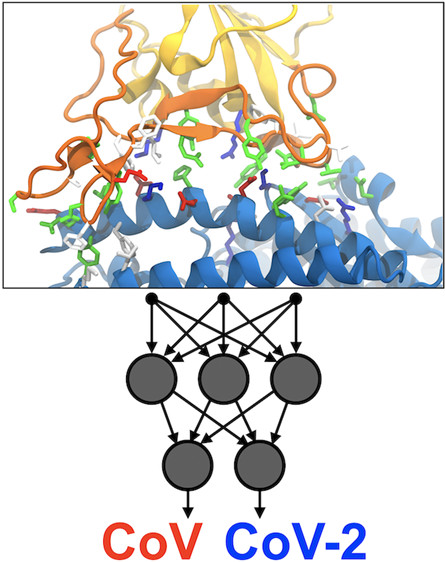

Following prior analysis, we wish to compare how the receptor binding domains (RBDs) for SARS-
CoV and SARS-CoV-2 bind to ACE2. Although there is a substantial portion of the SARS-CoV sequence
conserved in SARS-CoV-2, the large number of differing residues within the RBD makes analyzing each
change individually very difficult (a very large combinatorial problem). To combat the problem of iterating through a large number of possible comparisons, we will use three ML algorithms to extract which residues are most important to the differences in binding affinity to ACE2 between the two viruses. This will be done by analyzing the change in pairwise residue distances between the RBD and ACE2 over time.

Here we will use multiple different supervised learning techniques. These methods can be used to predict
a classification. That is, if you were to feed a trained supervised learning algorithm a particular dataset, it would theoretically output a classification or label that describes that data. Here, we do not want to predict whether a set of MD trajectory data belongs to CoV or CoV2 (we know that already), but rather use the trained algorithm to give us information as to which features (residues) are most important to the discrimination between the two labels. Therefore, the process of our analysis (schematic shown in Figure 1) will be outlined within the next section.

**Obtain and process MD trajectory data**

While this workshop is not primarily focused on running MD simulations, it is helpful to understand the
nature of the data we will be working with. Generally, MD simulations allow us to model the movements
of atoms, molecules, and even entire proteins. These simulations work by predicting atomic movements
based on energy potentials influenced by surrounding atoms, using fundamental principles of statistical
mechanics. MD simulations are typically run with small time steps, often on the order of 2 femtoseconds
(fs) (1 fs = 10−15 s). As a result, the computational cost of these simulations increases significantly with
both the duration and size of the simulated structure, so simulating a system like the SARS-CoV/ACE2
interaction generates a vast amount of data to process and analyze.

It is not feasible to run full MD simulations over the course of this workshop, so instead we will work
with a collection of data that has already been generated. We will analyze these data using multiple machine
learning methods and determine the consistency of the results across different approaches. By comparing
the outcomes from various techniques, we can gain a better understanding of the reliability and robustness
of our findings, ultimately leading to more accurate insights and predictions. The dataset we will look at
consists of pairwise distances between the nearest heavy atoms associated with residues (amino acids) in
the RBD and in ACE2. Each row within the dataframes will thus correspond to a single frame and each
column to a pairwise distance between residues. The residues associated with these pairs are notated within
a separate dataframe, which we will also use for this analysis. Since residue numbers may vary between
SARS-CoV and SARS-CoV-2, it is important to make sure that we compare the aligned residues, rather
than the same residue numbers, to avoid confounding information.

For the analysis associated with this workshop, we will also truncate the amount of data being processed;
otherwise, the computations would take upwards of 30 minutes to run, which is inconvenient and infeasible
for an introductory workshop. Therefore, we will remove a substantial proportion of the trajectory frames,
which should still allow us to see residue importance, just at a slightly lower accuracy and over a shorter amount of computational time. We will also do some additional data processing, which will be explained
within the subsequent sections.

If you are interested, this is the original publication that this work was done in.

[Machine Learning Reveals the Critical Interactions for SARS-CoV-2 Spike Protein Binding to ACE2](https://pubs.acs.org/doi/10.1021/acs.jpclett.1c01494)

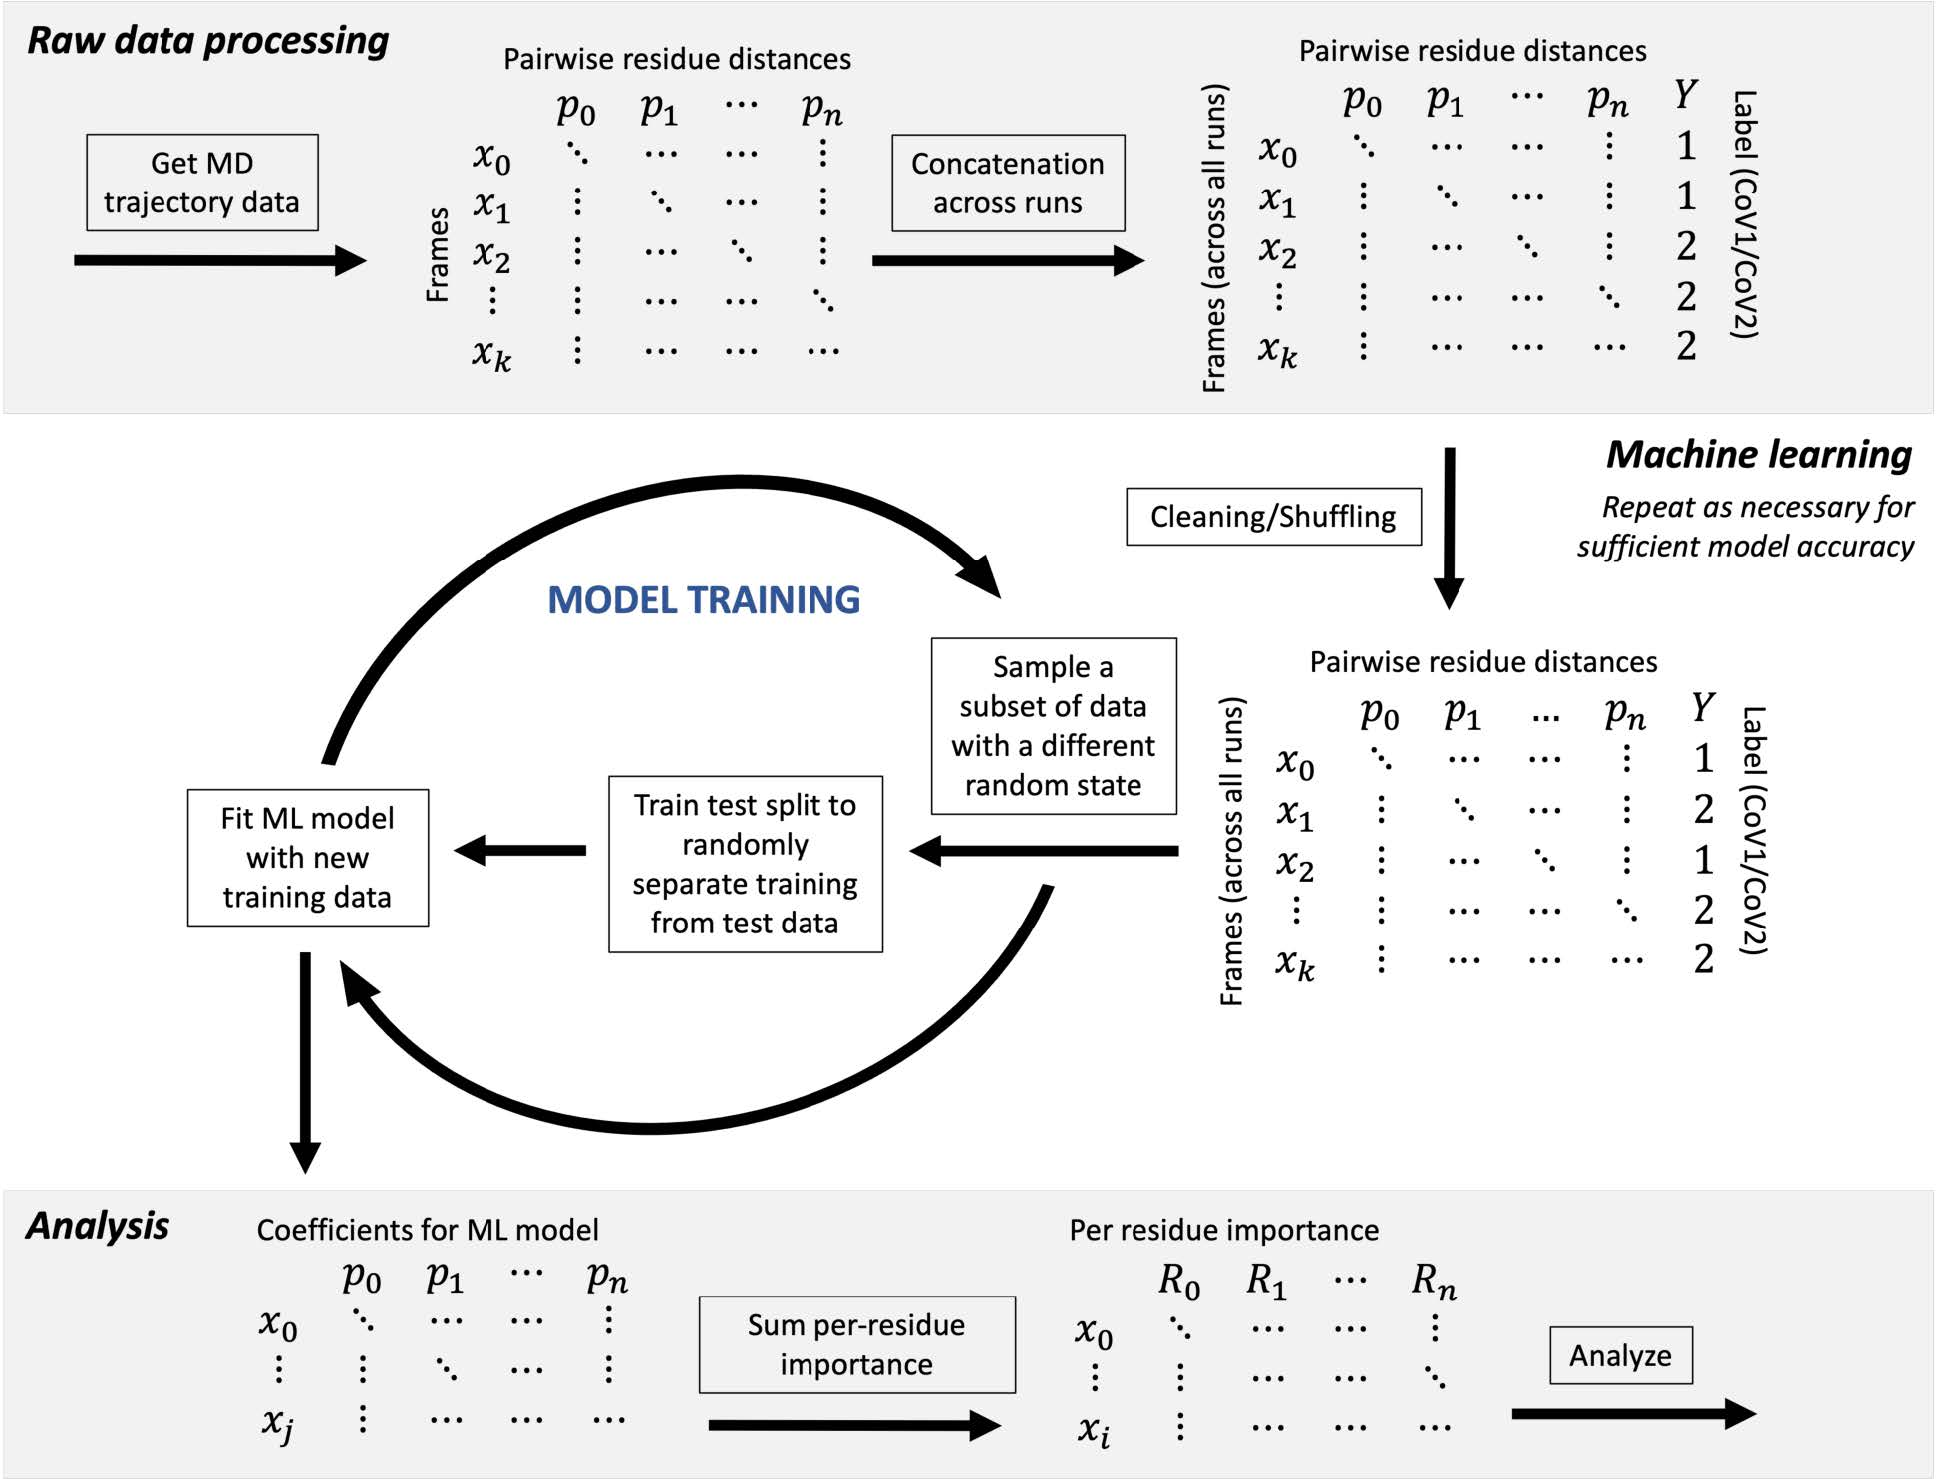

**Training the ML models**

We will train a random forest model, a logistic regression model, and a Multilayer Perceptron (MLP)
model using the data obtained from our MD trajectories, following methods similar to those outlined in our
introductory machine learning tutorial. After training these models, we will obtain a dataframe containing
information about the most critical residue pairs in determining the differences between SARS-CoV and
SARS-CoV-2.

**Analysis of residue importance**

Since we have pairwise importance information, we will need to process these results to indicate which
individual residues are most important in differentiating SARS-CoV from SARS-CoV-2. We will then plot
these results and visually analyze the structures for these particular residues.

# 2.1 Loading and formatting the first dataset

Before we begin with our project, it will be easier if we import all of the required modules.

If you run this block and don't see any errors, you can proceed without fear that you are missing any required modules in your Python environment.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import os
import sys
import time

from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, f1_score, precision_score, auc,roc_auc_score,roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import (recall_score,accuracy_score,confusion_matrix, f1_score, precision_score, auc,roc_auc_score,roc_curve, precision_recall_curve,classification_report)


from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier

By opening the link > QBioS2023-tutorial-files> Tutorial2_ML_inputdata > 
You should have six files: two samples of both SARS-CoV and SARS-CoV-2 and two files indicating pairs in Cov1 and Cov2, respectively. 

In [3]:
#This assumes the files are in the current directory
data_direct = '/home/jupyter/gatech-MLforMD/tutorial_files/ML_input_files/'
num_runs_each = 1000

#Load datasets and ensure all are the same dimension. Also note that you may need to change the file directory
cov1_run1 = np.load (data_direct + 'cropped_cov1_run1.npy')
# truncate these datasets so that all four runs have the same dimension
cov1_run2 = np.load (data_direct + 'cropped_cov1_run2.npy')
cov2_run1 = np.load (data_direct + 'cropped_cov2_run1.npy')
cov2_run2 = np.load (data_direct + 'cropped_cov1_run2.npy')

#Load data that contains information about pairing between ACE and SARS residues
cov1_pairs = np . loadtxt (data_direct + 'cov1pairs_resids.15.txt', dtype = int )
cov2_pairs = np . loadtxt (data_direct + 'cov2pairs_resids.15.txt', dtype = int )

If you want, you can determine the size of the data by calling \\
`cov1_run1.shape`


To be clear, the rows refer to frames of the simulations, and the columns refer to the distances between the residue pair at each frame. The cov1\_pairs and cov2\_pairs arrays tell us which residue pairs are associated with each column of the runs. For example, the first row of the cov1\_pairs array tells us that the pair distances in the first column of the data is referring to residues 21 and 402.

The large data files we have here compiled a series of distances between residues sampled from molecular dynamics simulations. As residues which are closest in physical space are likely to interact and therefore have a greater impact on the dynamics of the protein, it is reasonable to define co-residue importance by an inverse distance relationship, so small distances will yield a large value. We will store the four data files in a pandas data frame (which contains residue distance data) and then take the inverse of each data point to obtain a measurement of residue `importance'.


In [4]:
#create concetenated dataframe
df = pd.DataFrame(np.concatenate((cov1_run1,cov1_run2,cov2_run1,cov2_run2),axis=0))

We concatenate the data frame and set \\
    `axis = 0`

The coefficient values in logistic regression and neural network models can be influenced by the scale of input features. To eliminate this unwanted effect, we standardize the pairwise distances before training the models. By doing so, we ensure that each feature has a mean of 0 and a standard deviation of 1, which allows for a more accurate and unbiased comparison of the importance of each feature in the models. This preprocessing step helps improve the performance and interpretability of the models.



In [5]:
#take inverse to more intuitively quantify residue importance
df = 1/df
#this is the standard scalar
df_scaled = (df-df.mean(axis=0))/df.std(axis=0)

We wish to initiate a supervised learning algorithm. This means that we will need to identify which rows of our dataframe correspond to SARS-CoV and SARS-CoV-2. Our machine learning method will then fit a model that will classify each residue interaction as belonging to SARS-CoV or SARS-CoV-2 with an accuracy of 1. To this end, we can add a column to our dataframe that contains a label associating each row with the respective SARS virus. This will become very important as we will begin to shuffle rows of the dataframe within the next few sections.

In [6]:
row_bound = num_runs_each*2 #where CoV-1 ends and CoV-2 begins
df_scaled['cov'] = 'cov'
df_scaled.iloc[:row_bound, -1] = 1
df_scaled.iloc[row_bound:, -1] = 2

In this tutorial, it is important to address the issue of highly correlated features when processing MD data. Highly correlated features are variables that exhibit a strong linear relationship with each other, carrying almost the same information. Including all of them in a model can lead to multicollinearity, a problem that makes it challenging to determine the independent effect of each feature on the target variable \autocite{multicollinearity}. To mitigate this issue, it is advisable to remove features with high correlation during data preprocessing (which we will do in the next section). This approach can improve the efficiency and accuracy of our prediction models, leading to more reliable insights into the differences between SARS-CoV and SARS-CoV-2.

In [7]:
#pull out all features from the dataframe (everything except for the last ID column)

features_pre = df_scaled.iloc[:,:-1]
print('# of features before drop:', features_pre.shape[1]+1)

# of features before drop: 4887


We are now going to generate a correlation matrix for our data. We will then remove all columns which contain any value above a cutoff threshold.
>⏰ This run can take about 4 minutes

In [8]:
#create correlation matrix - if it is taking too long, increase the min_periods, but know this
#will lead to worse results
corr_matrix_before = features_pre.corr(min_periods=10).abs()

#set a cutoff threshold (usually 0.9 or 0.85)

cutoff = 0.9

# 1.2 Setting up algorithms to solve for per residue importances

We are going to look at three different ML methods and compare the output importance of each. In the previous tutorial, we looked at RF, LR, and MLP methods. We will use these same methods in the analysis of residue importance within our protein-binding system.
Let's initialize our models as follows:

In [9]:
#RF------------------------------
############################################

RF_tuned_params = {'max_depth': 60,
                   'max_features': 50,
                   'min_samples_leaf': 1,
                   'n_estimators': 500,
                   'n_jobs': -1,
                   'random_state': 42
                  }

RF = RandomForestClassifier(random_state=42,n_jobs=-1).set_params(**RF_tuned_params)
#RF------------------------------
############################################

#LR------------------------------
############################################

LR_tuned_params = {'C': 1,
                   'penalty': 'l1',
                   'solver': 'liblinear'
                  }

LR = LogisticRegression(random_state = 42).set_params(**LR_tuned_params)

#LR------------------------------
###########################################

#MLP-----------------------------
############################################
MLP = MLPClassifier(hidden_layer_sizes = (55), activation = 'relu', solver = 'adam', max_iter= 1000)

Before continuing we will need to implement a method to sum the importance of residues across all pairs.

## **Challenge Problem 1**: Generate a function to calculate residue importance

>Given an array of importances across pairs, generate one array that contains the residue numbers (no repeats), then cycle through the entire vector, summing the importance for each respective residue. Finally, normalize these vectors so that the maximum value of importance is 1.
  

In [ ]:
# Start your code here:

<details>
    <summary> Challenge 1 Solution</summary>
    <pre> <code>
# Challenge Problem 1 Solution #

def sum_elements(i_array):
    #calculate residue importance

    resid = []
    for i in i_array:
        if i[0] not in resid:
            resid.append(i[0]) #get array of residues with no repeats
    import_sum = []
    for i in resid:
        su = 0
        for j in i_array:
            if j[0] == i:
                su = su + j[1]
        import_sum.append([i,su])
    import_sum = np.array(import_sum)
    xmax, ymax = import_sum.max(axis=0)
    import_sum[:,1] /= ymax
    import_sum = import_sum[import_sum[:,0].argsort()]
    return import_sum
     
 </code>
</pre>
</details>

We also need to define output dataframes to store the information calculated from our ML analysis. We will initialize a set of dataframes that encompass all of the interacting residues that we want to look at. This will be residues 336-519 for SARS-CoV-2, 323-503 for SARS-CoV, and 21-616 for ACE2.

In [10]:
#create dfs to store per-residue importance results from the ML algorithms
LR_impo_res_cov2=pd.DataFrame(columns = range(336,519))
RF_impo_res_cov2=pd.DataFrame(columns = range(336,519))
LR_impo_res_cov1=pd.DataFrame(columns = range(323,503))
RF_impo_res_cov1=pd.DataFrame(columns = range(323,503))
LR_impo_res_ace=pd.DataFrame(columns = range(21,616))
RF_impo_res_ace=pd.DataFrame(columns = range(21,616))
mlp_impo_res_cov2=pd.DataFrame(columns = range(336,519))
mlp_impo_res_cov1=pd.DataFrame(columns = range(323,503))
mlp_impo_res_ace=pd.DataFrame(columns = range(21,616))

# 1.3 Adjustments when training ML models on our large datasets

We will drop any columns that have a correlation greater than the cutoff value that we set initially. As stated previously, this step is important in order to ensure that our machine-learning algorithms provide accurate results. Exploring the effects of skipping this step is left as a separate exercise for the reader. The algorithm for performing this dropping scenario is as follows:

In [11]:
#shuffle corr_matrix
arr = np.arange(len(df_scaled.columns)-1)
np.random.shuffle(arr) #there are other functions/method for shuffling these rows, free free to use any that you prefer and compare the results
corr_matrix = corr_matrix_before.iloc[arr,arr]

#select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

#drop highly correlated features based on set threshold
to_drop = [column for column in upper.columns if any(upper[column] > cutoff)]
df_dropped = df_scaled.drop(columns = to_drop)

This shuffling will be conducted 20 times, such that each ML model will be trained from a slightly different collection of data, increasing the overall accuracy of our final model and thus our results.

# 1.4 Training and evaluating our ML algorithms

Using the setup that we have created above with the basics of ML from the previous tutorial, we will now perform our analysis.

## **Challenge Problem 2**: Logistic Regression, let's do some real work!

>Complete the code block below to develop an algorithm to prep for the implementation of an LR analysis (fill in the ellipses)
>> ⏰This run can take about 3 minutes.

In [12]:
startTime = time.time()
for run in range(0,20):
    ##?correlation matrix shuffling and dropping from previous code block
    ....
    .
    .
    ....

    ########LR part
    X = df_dropped.iloc[:,:-1] #pairwise residue information
    y = df_dropped['cov'] #classification column

    X, y = X.to_numpy(),y.to_numpy()

    #initialize df to store information about importance from our LF model
    df_lr_coef = pd.DataFrame(columns = df_dropped.columns[:-1])

    ##?consider the input and output data. Use the proper function for splitting the data for training and testing
    X_train, X_test, y_train, y_test = ...(...,...,test_size = 0.20, random_state = 42)

    for rndm_state in range(0,1) :
        ##?What is the input and ouput of the split data used for training?
        X_train_resampl,y_train_resampl = resample(...,..., n_samples=len(X_train), random_state= rndm_state)

        y_train_resampl=y_train_resampl.astype('int') #change column to have integer datatype, rather than object


        #create a dataframe to store test set performance
        f1,prec,recall,acc,ROC_AUC,conf = ([],[],[],[],[],[])

        #evaluate the performance of LR, hyperparameters were tuned for an accuracy of 1
        model_name = 'LR'
        clf = eval(model_name)

        ##?What is the resampled input data?
        clf.fit(..., y_train_resampl.ravel())
        df_lr_coef = df_lr_coef.append(pd.DataFrame(clf.coef_, columns = df_dropped.columns[:-1]), ignore_index=True)

    df_lr_coef_mean_abs = abs(df_lr_coef.mean().to_frame().T)

    #assign importance to per-residue
    cov1_impor_resids = []
    cov2_impor_resids = []
    ace_impor_resids = []

    for col in df_lr_coef_mean_abs.columns.values:
        importance = df_lr_coef_mean_abs.at[0,col]
        ace_impor_resids.append([cov1_pairs[col][0],importance])
        cov1_impor_resids.append([cov1_pairs[col][1],importance])
        cov2_impor_resids.append([cov2_pairs[col][1],importance])

    ##use our previously written sum importance function
    lr_cov2_impor_resids_sum = ...(cov2_impor_resids)
    lr_cov1_impor_resids_sum = ...(cov1_impor_resids)
    lr_ace_impor_resids_sum = ...(ace_impor_resids)

    #append to df
    LR_impo_res_cov2 = LR_impo_res_cov2.append(pd.DataFrame(np.reshape(lr_cov2_impor_resids_sum[:,1], (1,len(lr_cov2_impor_resids_sum))), columns = lr_cov2_impor_resids_sum[:,0]))
    LR_impo_res_cov1 = LR_impo_res_cov1.append(pd.DataFrame(np.reshape(lr_cov1_impor_resids_sum[:,1], (1,len(lr_cov1_impor_resids_sum))), columns = lr_cov1_impor_resids_sum[:,0]))
    LR_impo_res_ace = LR_impo_res_ace.append(pd.DataFrame(np.reshape(lr_ace_impor_resids_sum[:,1], (1,len(lr_ace_impor_resids_sum))), columns = lr_ace_impor_resids_sum[:,0]))

SyntaxError: invalid syntax (325121459.py, line 4)

<details>
    <summary> Challenge Problem 2 Solution </summary>
    <pre>
        <code>
# Challenge Problem 2 Solution #

for run in range(0,20):

    #correlation matrix shuffling and dropping

    #shuffle corr_matrix
    arr = np.arange(len(df_scaled.columns)-1)
    np.random.shuffle(arr)
    corr_matrix = corr_matrix_before.iloc[arr,arr]

    #select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    #drop highly correlated features based on set threshold
    to_drop = [column for column in upper.columns if any(upper[column] > cutoff)]
    df_dropped = df_scaled.drop(columns = to_drop)

    ########LR part
    X = df_dropped.iloc[:,:-1]
    y = df_dropped['cov']

    X, y = X.to_numpy(),y.to_numpy()

    df_lr_coef = pd.DataFrame(columns = df_dropped.columns[:-1])

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 42) #same random_state as previous GS

    for rndm_state in range(0,1) :
        X_train_resampl,y_train_resampl = resample(X_train,y_train, n_samples=len(X_train), random_state= rndm_state)

        y_train_resampl=y_train_resampl.astype('int')
        #create a dataframe to store test set performance
        f1,prec,recall,acc,ROC_AUC,conf = ([],[],[],[],[],[])

        #evaluate the performance of LR, hyperparameters were tuned for an accuracy of 1
        model_name = 'LR'
        clf = eval(model_name)
        clf.fit(X_train_resampl, y_train_resampl.ravel())
        df_lr_coef = df_lr_coef.append(pd.DataFrame(clf.coef_, columns = df_dropped.columns[:-1]), ignore_index=True)

    df_lr_coef_mean_abs = abs(df_lr_coef.mean().to_frame().T)

    #assign importance to per-residue
    cov1_impor_resids = []
    cov2_impor_resids = []
    ace_impor_resids = []

    for col in df_lr_coef_mean_abs.columns.values:
        importance = df_lr_coef_mean_abs.at[0,col]
        ace_impor_resids.append([cov1_pairs[col][0],importance])
        cov1_impor_resids.append([cov1_pairs[col][1],importance])
        cov2_impor_resids.append([cov2_pairs[col][1],importance])

    #use our previously written sum importance function
    lr_cov2_impor_resids_sum = sum_elements(cov2_impor_resids)
    lr_cov1_impor_resids_sum = sum_elements(cov1_impor_resids)
    lr_ace_impor_resids_sum = sum_elements(ace_impor_resids)

    #append to df
    LR_impo_res_cov2 = LR_impo_res_cov2.append(pd.DataFrame(np.reshape(lr_cov2_impor_resids_sum[:,1], (1,len(lr_cov2_impor_resids_sum))), columns = lr_cov2_impor_resids_sum[:,0]))
    LR_impo_res_cov1 = LR_impo_res_cov1.append(pd.DataFrame(np.reshape(lr_cov1_impor_resids_sum[:,1], (1,len(lr_cov1_impor_resids_sum))), columns = lr_cov1_impor_resids_sum[:,0]))
    LR_impo_res_ace = LR_impo_res_ace.append(pd.DataFrame(np.reshape(lr_ace_impor_resids_sum[:,1], (1,len(lr_ace_impor_resids_sum))), columns = lr_ace_impor_resids_sum[:,0]))
    
</code></pre>
</details>

## **Challenge Problem3**: Deep into the random forests

>Using the same method as before, copy your previous code and revise it to include a random forest model. We will compare the results from these two methods, so don't delete your working LR code.
>>❗⏰ This code will take about 20 minutes to run. So be patient!

In [13]:
for run in range(0,20):
    ##?correlation matrix shuffling and dropping from previous code block
    ......
    .
    .
    ......

    #######RF part
    #set up X and y the same as for the LR method
    .....
    .
    .
    .....

    #random_state, we won't loop through 50 random states for this training
    rndm_state= 42

    #train_test_split using our chosen random state and a test size of 0.20
    .....

    #create a dataframe to store test set performance
    f1,prec,recall,acc,ROC_AUC,conf = ([],[],[],[],[],[])
    y_train=y_train.astype('int')

    #evaluate the performance of RF ,hyperparameters were tuned for an accuracy of 1
    model_name = 'RF'
    #fit the model using the same method as before
    ....
    .
    .
    ....
    df_rf_coef = pd.DataFrame(np.reshape(clf.feature_importances_, (1,num_features)), columns = df_dropped.columns[:-1])

    #assign importance to per-residue
    cov1_impor_resids = []
    cov2_impor_resids = []
    ace_impor_resids = []


    for col in df_rf_coef.columns.values:

        importance = df_rf_coef.at[0,col]

        ace_impor_resids.append([cov1_pairs[col][0],importance])
        cov1_impor_resids.append([cov1_pairs[col][1],importance])
        cov2_impor_resids.append([cov2_pairs[col][1],importance])


    #use our previous sum importance function to quantify residue importance
    rf_cov2_impor_resids_sum = ...
    rf_cov1_impor_resids_sum = ...
    rf_ace_impor_resids_sum = ...


    #append to df in the same way as we did for the LR method -- make sure to change the names of arrays from containing 'LR' to 'RF' identifiers
    .....
    .
    .
    .
    .
    .....


SyntaxError: invalid syntax (1405359374.py, line 3)

<details>
    <summary> Challenge Problem 3 Solution </summary>
    <pre>
        <code>
# Challenge Problem 3 Solution #

#######RF part
for run in range(0,20):
    #correlation matrix shuffling and dropping

    #shuffle corr_matrix
    arr = np.arange(len(df_scaled.columns)-1)
    np.random.shuffle(arr)
    corr_matrix = corr_matrix_before.iloc[arr,arr]

    #select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    #drop highly correlated features based on set threshold
    to_drop = [column for column in upper.columns if any(upper[column] > cutoff)]
    df_dropped = df_scaled.drop(columns = to_drop)


    #set up X and y the same as for the LR method
    X = df_dropped.iloc[:,:-1]
    y = df_dropped['cov']
    num_features = X.shape[1]

    X, y = X.to_numpy(),y.to_numpy()

    #random_state
    rndm_state=42

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = rndm_state) #same random_state as previous GS

    #create a dataframe to store test set performance
    f1,prec,recall,acc,ROC_AUC,conf = ([],[],[],[],[],[])
    y_train=y_train.astype('int')
    #evaluate the performance of RF ,hyperparameters were tuned for an accuracy of 1
    model_name = 'RF'
    clf = eval(model_name)
    clf.fit(X_train, y_train.ravel())
    df_rf_coef = pd.DataFrame(np.reshape(clf.feature_importances_, (1,num_features)), columns = df_dropped.columns[:-1])

    #assign importance to per-residue
    cov1_impor_resids = []
    cov2_impor_resids = []
    ace_impor_resids = []


    for col in df_rf_coef.columns.values:

        importance = df_rf_coef.at[0,col]

        ace_impor_resids.append([cov1_pairs[col][0],importance])
        cov1_impor_resids.append([cov1_pairs[col][1],importance])
        cov2_impor_resids.append([cov2_pairs[col][1],importance])

    #use our previous sum importance function to quantify residue importance
    rf_cov2_impor_resids_sum = sum_elements(cov2_impor_resids)
    rf_cov1_impor_resids_sum = sum_elements(cov1_impor_resids)
    rf_ace_impor_resids_sum = sum_elements(ace_impor_resids)

    #append to df in the same way as we did for the LR method -- make sure to change the names of arrays from containing 'LR' to 'RF' identifiers
    RF_impo_res_cov2 = RF_impo_res_cov2.append(pd.DataFrame(np.reshape(rf_cov2_impor_resids_sum[:,1], (1,len(rf_cov2_impor_resids_sum))), columns = rf_cov2_impor_resids_sum[:,0]))
    RF_impo_res_cov1 = RF_impo_res_cov1.append(pd.DataFrame(np.reshape(rf_cov1_impor_resids_sum[:,1], (1,len(rf_cov1_impor_resids_sum))), columns = rf_cov1_impor_resids_sum[:,0]))
    RF_impo_res_ace = RF_impo_res_ace.append(pd.DataFrame(np.reshape(rf_ace_impor_resids_sum[:,1], (1,len(rf_ace_impor_resids_sum))), columns = rf_ace_impor_resids_sum[:,0]))
    
</code></pre>
</details>

## **Challenge Problem 4**: **M**ulti-**L**ayer **P**erceptron neural network, enough for algorithms!

>Implement the MLP neural network algorithm. For an additional challenge, try to do this without the code outline below.
>>⏰ This run can take about 4 minutes.

In [ ]:
 #MLP section
cut_th = 0.9

for run in range(0,20):
    #shuffle correlation matrix
    .....
    .
    .
    .....

    #set up X and y

    ....
    .
    .
    ....
    #convert labels to one hot code for MLP
    one_hot_y = y[:, None]==np.array([1,2])

    #train test split using one_hot_y instead of y
    .....

    #fit the model
    .....

    ####Layer-Wise Relevance Propagation
    #Feature importance was extracted from MLP using Layer-Wise Relevance Propagation (LRP)
    W = clf.coefs_
    B = clf.intercepts_
    L = len(W)
    A = [X]+[None]*L
    for l in range(L):
        A[l+1] = np.maximum(0,A[l].dot(W[l])+B[l])

    R = [None]*L + [A[L]*one_hot_y]

    #LRP propagates relevance R from the output layer to the input layer thought the weights of the network and
    #neural activations. The propagation follows the LPR-0 rule
    for l in range(0,L)[::-1]:
        w = W[l]
        b = B[l]
        z = A[l].dot(w)+b
        s = R[l+1] / z
        c = s.dot(w.T)
        R[l] = A[l]*c

    #get each feature importance
    df_mlp_coef = pd.DataFrame(np.reshape(R[0].mean(axis=0), (1,X.shape[1])), columns = df_dropped.columns[:-1])

    #assign importance from features to each residue with sum_elements method and cov1,2_pairs datasets.
    cov1_impor_resids = []
    cov2_impor_resids = []
    ace_impor_resids = []

    for col in df_mlp_coef.columns.values:
        importance = df_mlp_coef.at[0,col]
        ace_impor_resids.append([cov1_pairs[col][0],importance])
        cov1_impor_resids.append([cov1_pairs[col][1],importance])
        cov2_impor_resids.append([cov2_pairs[col][1],importance])

    #use our sum elements function to determine residue importance
    ....
    .
    .
    .
    ....

    #append dataframes with residue importances

    ....
    .
    .
    .
    ....

<details>
    <summary> Challenge Problem 4 Solution </summary>
    <pre>
        <code>
# Challenge Problem 4 Solution #

cut_th = 0.9

#run 20 times
for run in range(0,20):
    #shuffle corr_matrix
    arr = np.arange(len(df_scaled.columns)-1)
    np.random.shuffle(arr)
    corr_matrix = corr_matrix_before.iloc[arr,arr]

    #keeping the upper (right) triangular matrix without the main diagonal
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    #removed a column (i.e., feature), if any element(s) in the column of the upper triangular matrix is/are
    #larger than the threshold value
    to_drop = [column for column in upper.columns if any(upper[column] > cut_th)]
    df_dropped = df_scaled.drop(columns = to_drop)
    X = df_dropped.iloc[:,:-1]
    y = df_dropped['cov']

    if type(X) is not np.ndarray:
        X, y = X.to_numpy(),y.to_numpy()
    else:
        print('X,y already converted to ndarray')

    #convert labels to one hot code for MLP
    one_hot_y = y[:,None]==np.array([1,2])
    X_train, X_test, y_train, y_test = train_test_split(X,one_hot_y,test_size = 0.20, random_state = 666)

    clf=MLP.fit(X_train, y_train)

    ####Layer-Wise Relevance Propagation
    #Feature importance was extracted from MLP using Layer-Wise Relevance Propagation (LRP)
    W = clf.coefs_
    B = clf.intercepts_
    L = len(W)
    A = [X]+[None]*L
    for l in range(L):
        A[l+1] = np.maximum(0,A[l].dot(W[l])+B[l])

    R = [None]*L + [A[L]*one_hot_y]

    #LRP propagates relevance R from the output layer to the input layer thought the weights of the network and
    #neural activations. The propagation follows the LPR-0 rule
    for l in range(0,L)[::-1]:
        w = W[l]
        b = B[l]
        z = A[l].dot(w)+b
        s = R[l+1] / z
        c = s.dot(w.T)
        R[l] = A[l]*c

    #get each feature importance
    df_mlp_coef = pd.DataFrame(np.reshape(R[0].mean(axis=0), (1,X.shape[1])), columns = df_dropped.columns[:-1])

    #assign importance from features to each residue with sum_elements method and cov1,2_pairs datasets.
    cov1_impor_resids = []
    cov2_impor_resids = []
    ace_impor_resids = []

    for col in df_mlp_coef.columns.values:
        importance = df_mlp_coef.at[0,col]
        ace_impor_resids.append([cov1_pairs[col][0],importance])
        cov1_impor_resids.append([cov1_pairs[col][1],importance])
        cov2_impor_resids.append([cov2_pairs[col][1],importance])

    #use our sum elements function to determine residue importance
    mlp_cov2_impor_resids_sum = sum_elements(cov2_impor_resids)
    mlp_cov1_impor_resids_sum = sum_elements(cov1_impor_resids)
    mlp_ace_impor_resids_sum = sum_elements(ace_impor_resids)

    #append dataframes with residue importances
    mlp_impo_res_cov2 = mlp_impo_res_cov2.append(pd.DataFrame(np.reshape(mlp_cov2_impor_resids_sum[:,1], (1,len(mlp_cov2_impor_resids_sum))), columns = mlp_cov2_impor_resids_sum[:,0]))
    mlp_impo_res_cov1 = mlp_impo_res_cov1.append(pd.DataFrame(np.reshape(mlp_cov1_impor_resids_sum[:,1], (1,len(mlp_cov1_impor_resids_sum))), columns = mlp_cov1_impor_resids_sum[:,0]))
    mlp_impo_res_ace = mlp_impo_res_ace.append(pd.DataFrame(np.reshape(mlp_ace_impor_resids_sum[:,1], (1,len(mlp_ace_impor_resids_sum))), columns = mlp_ace_impor_resids_sum[:,0]))
</pre></code>
</details>

# 1.5 Time to clean!

After your code has been run, clean the data (change any NaN values to zeros).

In [ ]:
RF_impo_res_cov2 = RF_impo_res_cov2.fillna(0)
LR_impo_res_cov2 = LR_impo_res_cov2.fillna(0)
mlp_impo_res_cov2 = mlp_impo_res_cov2.fillna(0)
RF_impo_res_cov1 = RF_impo_res_cov1.fillna(0)
LR_impo_res_cov1 = LR_impo_res_cov1.fillna(0)
mlp_impo_res_cov1 = mlp_impo_res_cov1.fillna(0)
RF_impo_res_ace = RF_impo_res_ace.fillna(0)
LR_impo_res_ace = LR_impo_res_ace.fillna(0)
mlp_impo_res_ace = mlp_impo_res_ace.fillna(0)

# 1.6 Take a breath, We are almost there!

Now that we have several dataframes of residue importances calculated from three different ML algorithms, we will analyze these data and determine which residues are crucial when determining the difference between binding affinity (and thus, in part, transmissibility) in SARS-CoV-2 versus SARS-CoV.

### **Challenge Problem 5**: Not a real challenge anymore

>Plot the results of residue importance for the different ML methods we tested and determine which residues appear to have the highest importance for this system (these values are saved in the XX\_impo\_res\_cov2 dataframes). Take the mean of each of these dataframes (dataframe.mean()), and then plot them using matplotlib. Here, we are going to consider residues with an importance greater than 0.7 for further analysis; indicate this cutoff on your figure (we suggest using *plt.hlines*).

In [ ]:
# Start your code here:

<details>
    <summary> Challenge Problem 5 Solution </summary>
    <pre>
        <code>
#get the final plot

LR_impo_res_cov2.mean().plot(figsize = (15,7), linewidth=3.0, color= 'black', label='LR')
RF_impo_res_cov2.mean().plot(figsize = (15,7), linewidth=3.0, color='red', label='RF')
mlp_impo_res_cov2.mean().plot(figsize = (15,7), xlim=(390, 519), linewidth=3.0, color = 'orange', label='MLP')
#plt.savefig(output_dir +'per-residue_importance_all.ave_20.eps', format='eps')
plt.hlines(0.7,390, 519,linestyles='dotted', colors='k', linewidth=3)

plt.xlabel('Residue number', fontsize=18, fontweight='bold')
plt.ylabel('Residue importance', fontsize=18, fontweight='bold')

plt.legend()
plt . savefig ( per - residue_importance_all . ave_20 . png ’, format =’png ’)

</code></pre> 

</details>

Your graph should look similar to this one below.

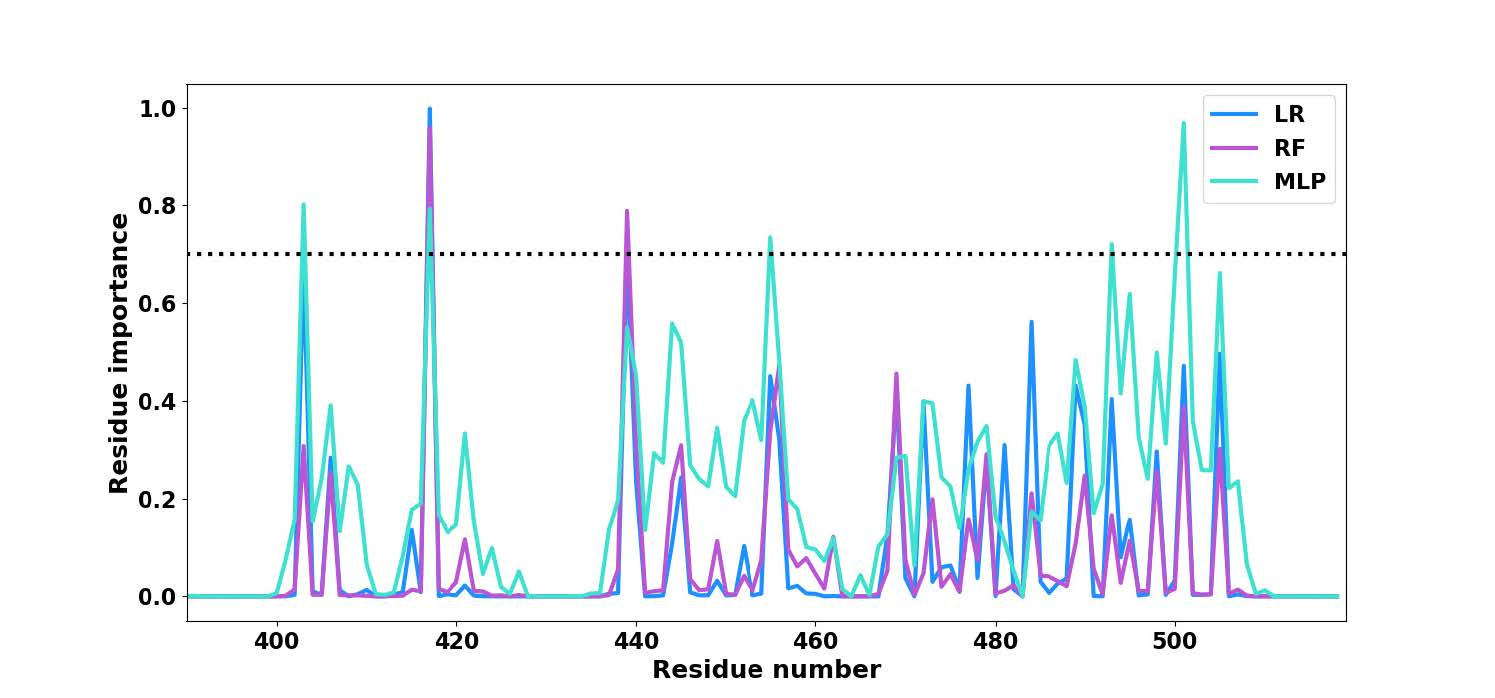
Dotted line at importance = 0.7 is used as a cutoff for further analysis.

# **2 - Next Step - Visualization of SARS: putting it all together** 

The previous tutorial focused on the analysis of MD trajectory data with the goal of determining residues
key for distinguishing between SARS-CoV and SARS-CoV-2. This tutorial will now outline how to visually analyze results from MD simulations and connect conclusions derived from our ML analysis to our protein
structures in context. To accomplish this, we will load MD trajectories in PyMOL and make observations
and inferences based on the apparent interactions between ACE2 and the SARS RBD.

Open a new pymol window, fetch the pdb 2AJF from the command line, and color by chain. You should
see four differently colored structures, two copies of the SARS rRBDs and the corresponding ACE2 receptor.

For this analysis, we only want to look at one set of these complexes, so type

In [ ]:
PyMOL> remove Chain B
PyMOL> remove Chain D
PyMOL> remove Chain F

into the command line.

Once this is done, we have a system containing ions, two proteins, and several ligands. Since we deleted
about half of our system, you may want to click ‘A  zoom’ to recenter and reorient the structure. For
the sake of this project, we will focus on analyzing the structure of the protein binding sites. We wish
to look at the interface between the ACE2 receptor and the SARS RBD and understand the differences
in interactions between amino acids within the RBD between SARS-CoV and SARS-CoV-2 to potentially
provide an explanation as to how the two viruses differ in effective binding.

Before we visualize trajectories obtained from MD simulations, we can initially visualize the distances
between atoms within the binding region. This will give us a general idea on the distance between the
residues, which can be used as a basis for examining more dynamic simulations. Although the ACE2-RBD
structure is much more complex than the structures we looked at in the previous PyMOL tutorial, we can
find a location of interest simply by observing the location where the two chains are closest (figure below).

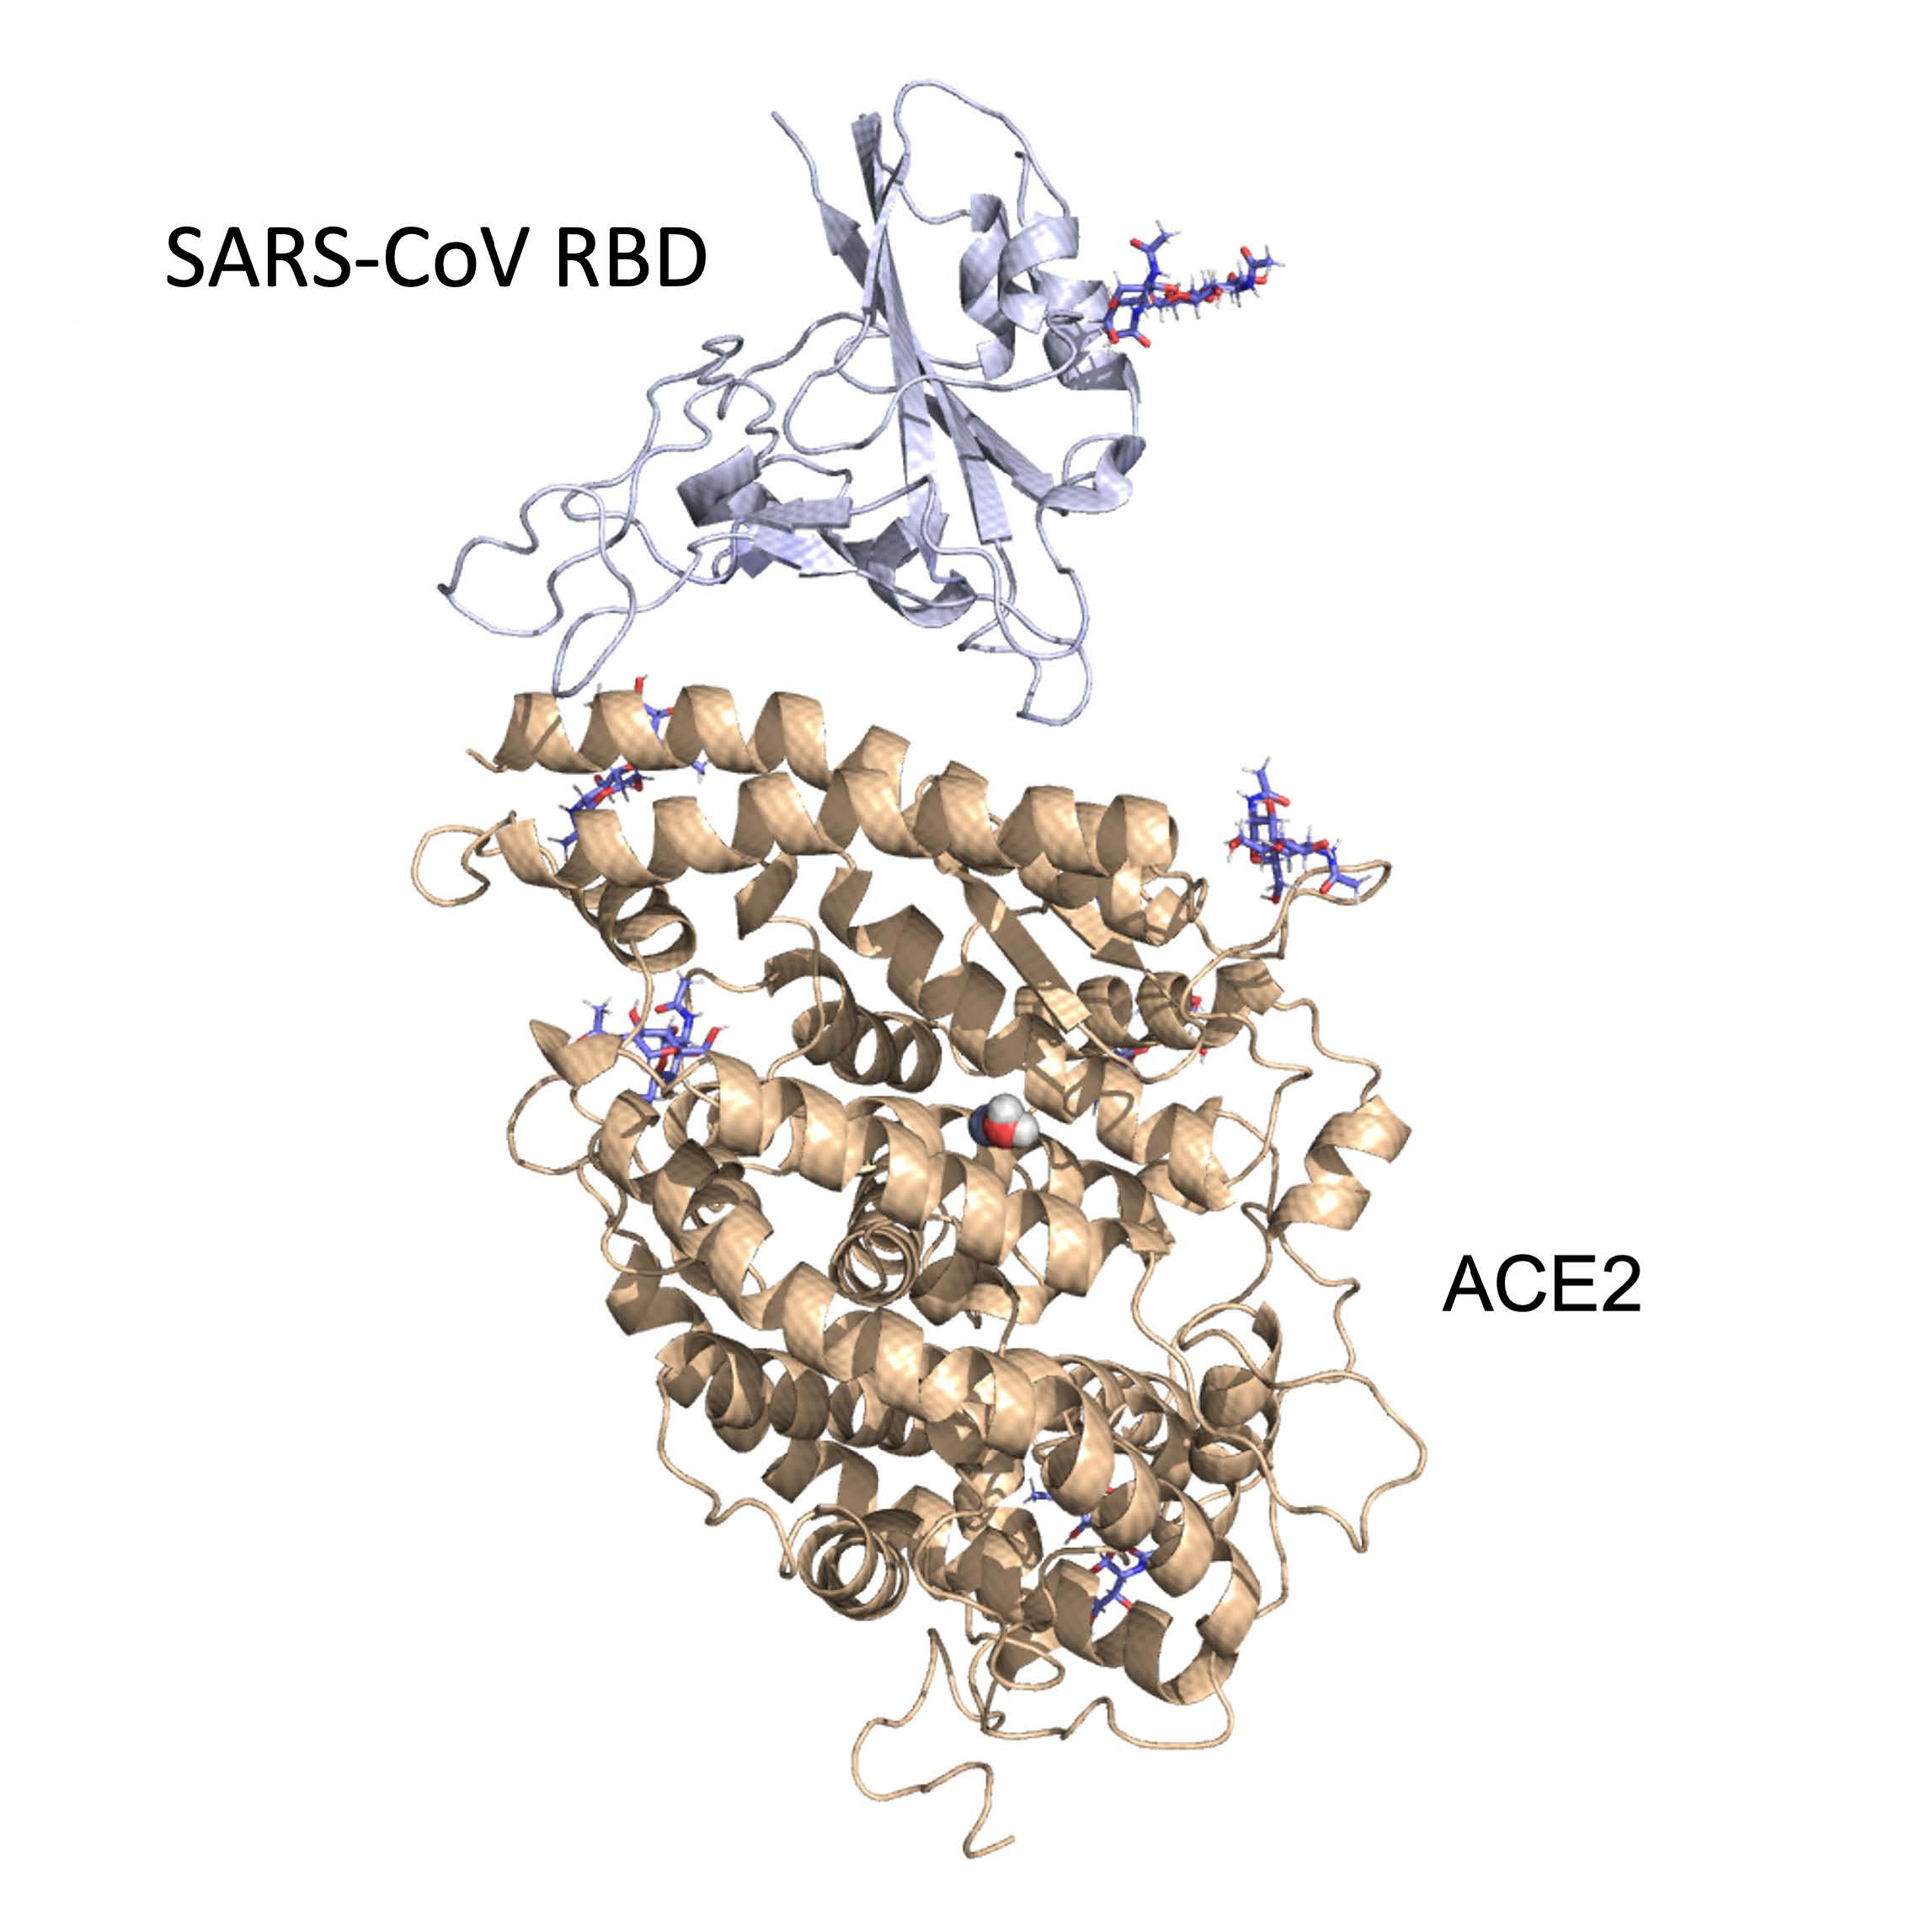
Visualization of SARS-CoV RBD with ACE2. The location where the two proteins meet is of interest to us as differences in chemical composition here will affect binding and thus transmissibility of SARS.

Find resi 426 (arginine, R) and resi 329 (glutamic acid, E) using the sequence viewer and show them in
licorice. In the toolbar, go to wizard ! measurement. Options will appear in the right-hand corner, where
the mouse commands are also listed. By default, the measurement wizard begins with distances, which is
what we need for this task. Click two close points on the two residues that we chose and observe the distance.

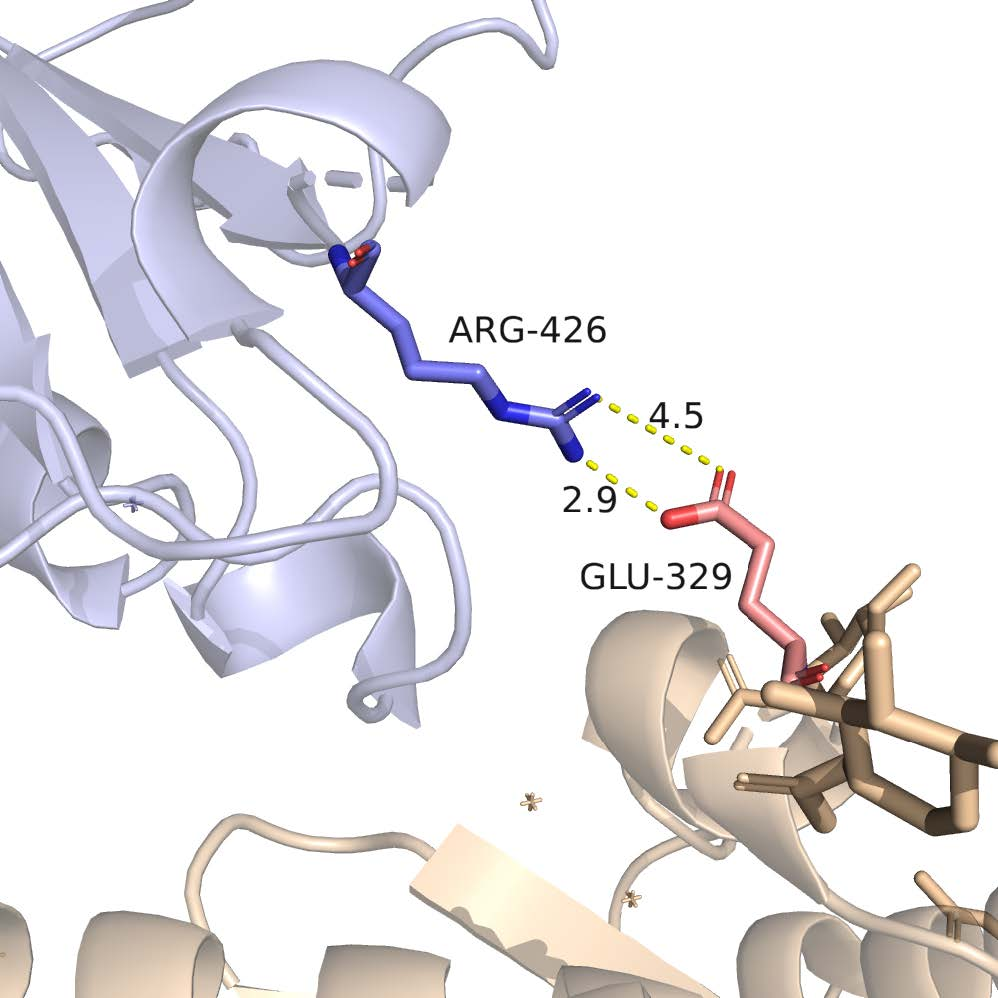
Distance between residues Arg426 and Glu329 for SARS-CoV and ACE2 (PDBID: 2AJF).

These distances are measured in °Angstroms; for context, the length of a C-C bond is approximately 1.5 °A
and the length of a hydrogen bond can range from 2.7-3.3 °A. Therefore, any distance around this range could indicate a potential interaction among residues.

# Challenge Problem 1: First inspection of SARS-CoV versus SARS-CoV-2

Align a SARS-CoV (PDBID: 2AJF) and SARS-CoV-2 (PDBID: 6M17) chain and determine if you can visually see any differences among the strands, especially near and within the RBDs. You will want to delete chains A-C, E, and G-O from the 6M17 pdb before aligning (to do this easily, type remove chain X and 6M17 in the PyMOL command line for each chain you wish to remove). The ACE2 proteins are not important here (they are the same for both protein files), so you should focus on the differences between the SARS proteins. Take a picture that illustrates a location within the SARS protein that noticeably differs between the two strains.

# Challenge Problem Solution

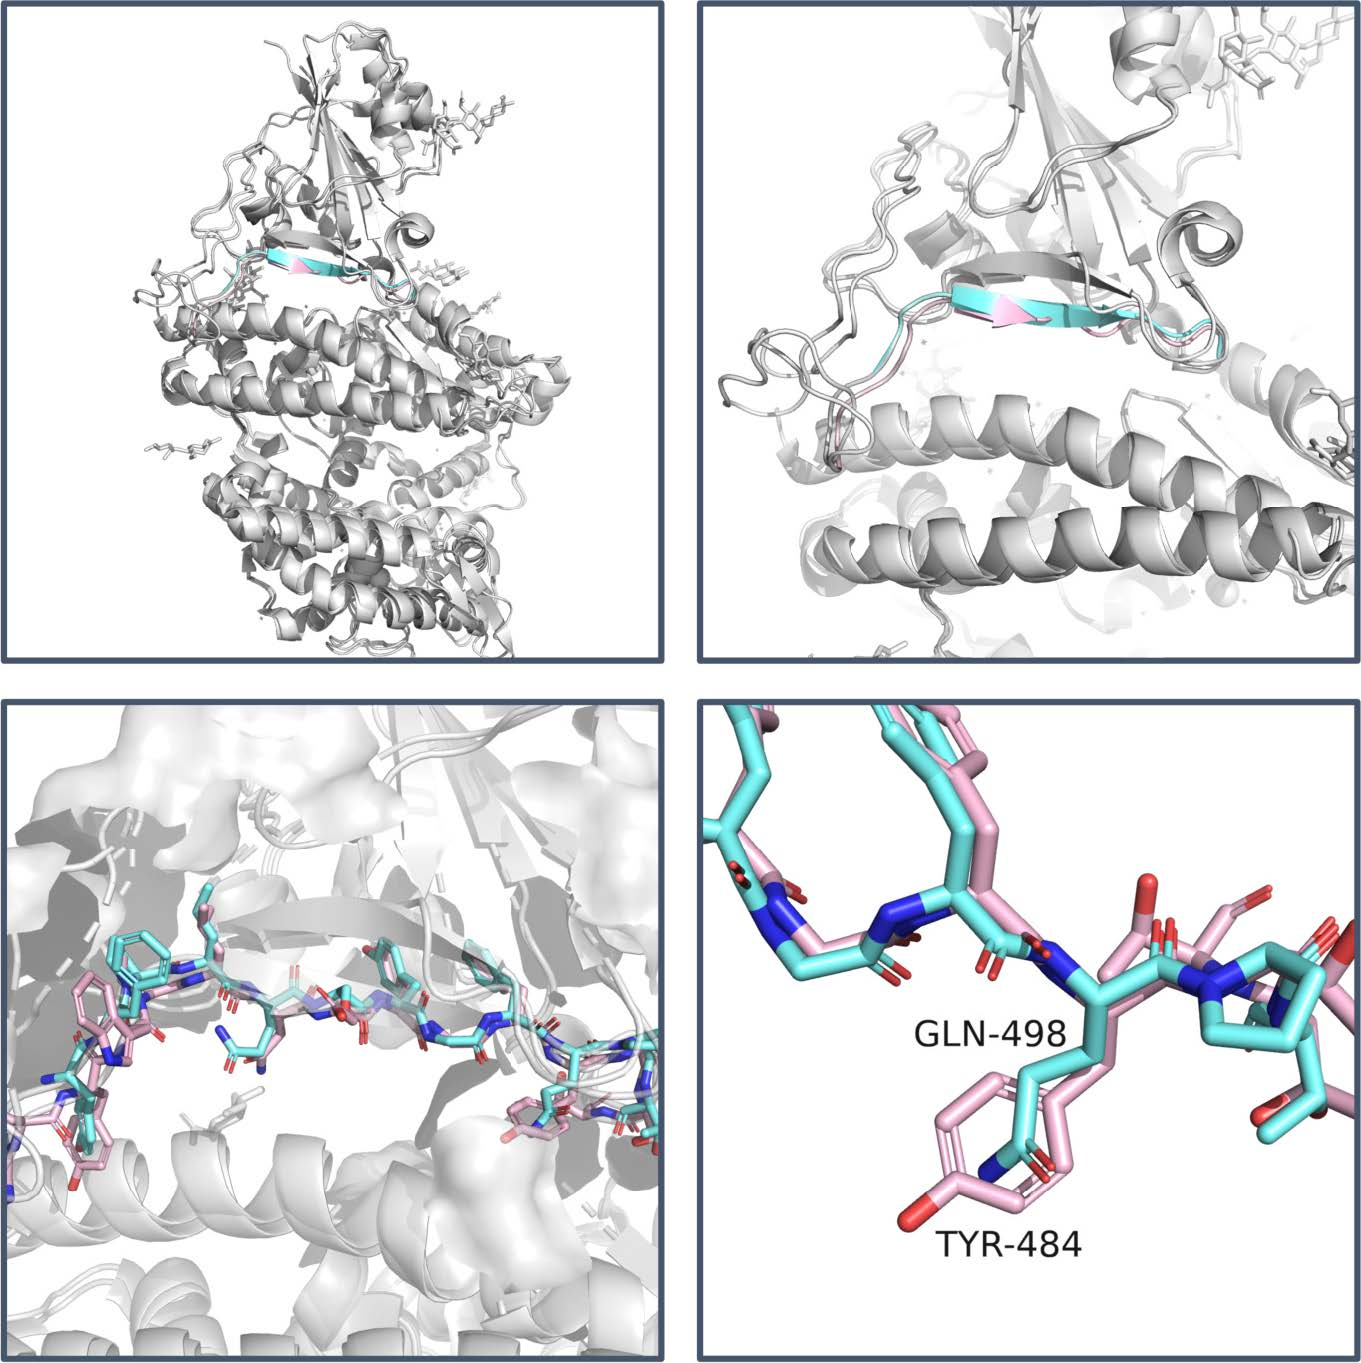
Example of the process of visually seeing a difference in structure between the SARS CoV (pink) and SARS
CoV-2 (cyan) and zooming in before focusing on the discrepancy at one amino acid location.

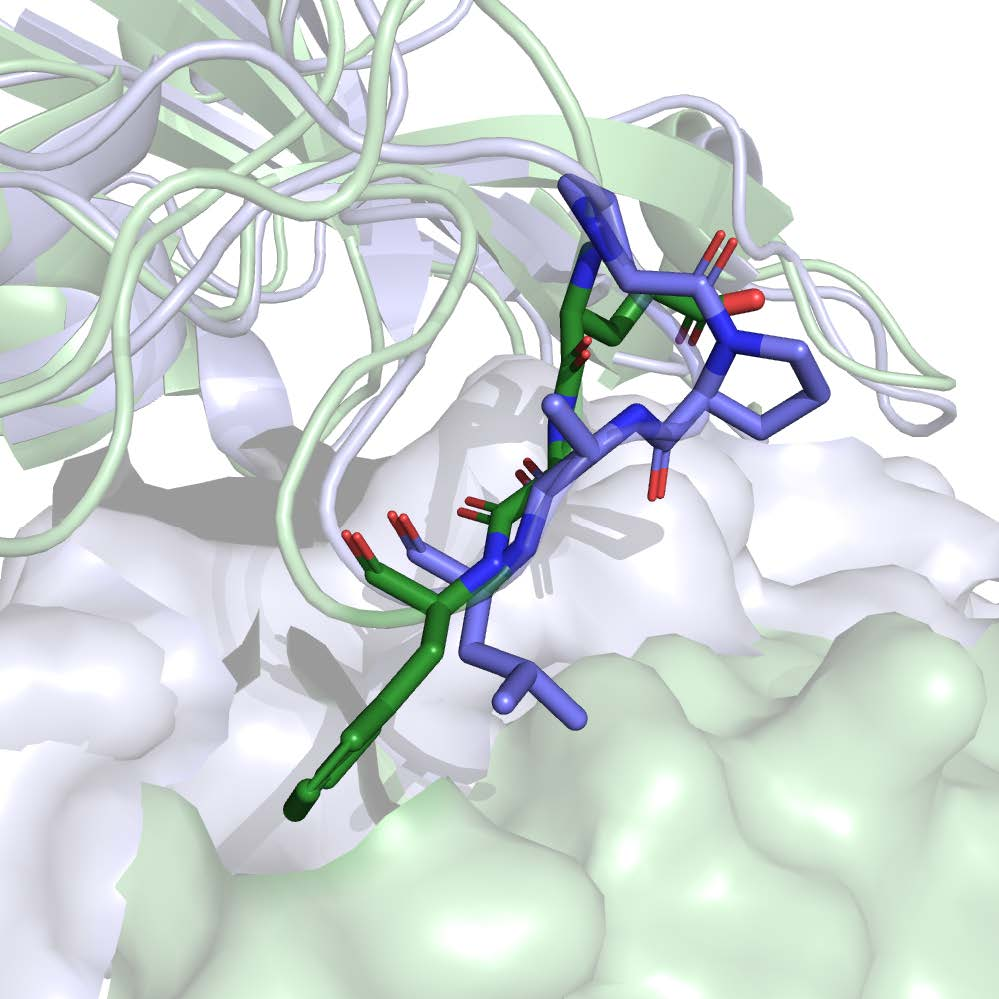
This is another example of a collection of residues that differ between the two SARS chains.

Now that you have explored a little on your own, look specifically at some of the differences in interactions between the RBD and ACE2 between CoV-1 and CoV-2. Compare the following sets of residues. It is helpful to note how the indices on the PyMOL sequence viewer are arranged; if you want to find residue 456, the corresponding residue will be marked under the 4 and not the 6.

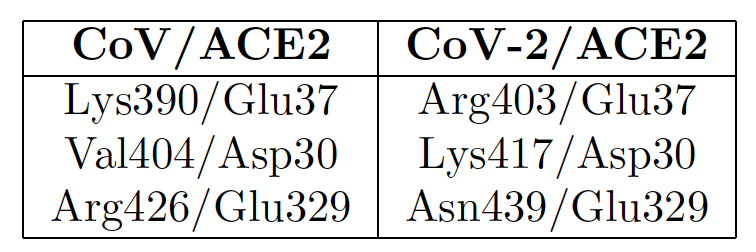

Can you determine which mutations are likely to be a reason as to why SARS-CoV-2 can more stably
bind to the ACE2 receptor protein? This isn’t always clear, and thus why we need to implement analysis
techniques such as our machine learning algorithms and other quantification methods. It is also worth
remembering that proteins are not static; the natural movement of the protein can cause residues to come
closer together or move farther apart, resulting in fluctuations of intermolecular interactions as a function of time.

# 2.1 Visualizing MD trajectories

The previous tutorials have served as an introduction both to using molecular visualization software and to protein analysis more generally. However, analysis of static proteins is generally trivial, and we can glean more fundamental information about the system via dynamics. In order to understand more about how the proteins in our system interact, we can run MD simulations on both a SARS-CoV and SARS-CoV-2 sample
to compare interactions of the RBD with the ACE2 protein receptor.

Download the sample trajectories from the folder "tutorial_files/MD_trajectories". Here, we have a .pdb file, which is a similar format to the files we have been ‘fetching’ through PyMOL. These files contain the atomic information of the protein. We also have multiple .dcd (trajectory) files that carry information about how each atom moves during an MD simulation. Using PyMOL, it is simple to view these trajectories. Open a new PyMOL window and type

In [ ]:
PyMOL> load CoV2-ng.nowat.pdb, CoV2_run1
PyMOL> load_traj CoV2-ng-run1.nowat-2us.dcd, CoV2_run1

In doing this, we are creating two objects, CoV run1 and CoV2 run1. If after loading the trajectories, you can no longer see the protein, click A ! center. You can then press the play button located near the sequence viewer button to watch the system’s movements over time.

Although it is simple to view an MD trajectory in PyMOL, it may be difficult to glean any meaningful
information at first glance. For instance, without alteration, it is difficult to tell apart visually the RBD and the ACE2 proteins. The ions used within the simulation also make it hard to see what is going on within the system. You can remove these by typing into the command line:

In [ ]:
PyMOL> remove resn SOD
PyMOL> remove resn CLA

Finally, the speed of frame movement is objectively too fast to be able to comprehend. You can adjust this setting via the command:

In [ ]:
PyMOL> set movie_fps, 10

Adjusting these settings to create a visually appealing movie will be the subject of the next challenge problem.

# Challenge Problem 2: Making a movie

Use your PyMOL skills to make a comprehensible movie. Remove non-protein atoms, color structures based on chains, and reduce the frame rate (if you have not already). If you would like, you can save this movie via the option within the ‘file’ toolbar or via the command ‘mpng nameofmovie’ in the command line.
Based on this movie, find two residues which are close together or exhibit seemingly interesting related movement behavior. Use the measurement wizard to find the distance between these residues or angles between residues (click on the word distances to change among measurement options; you could choose angles, dihedrals, or even polar contacts, if you would prefer), and observe how this value changes across the extent of the simulation (you may need to reduce the frame rate further to keep track of the moving protein).

# 2.2 Pinpointing key residues

From our previous analysis, we have determined that the SARS residues of greatest importance within this
system are 417, 455, 493, 403, 501, and 439 for the logistic regression method, 456, 455, 417, 403, 439, 445, 501 for the random forest method, and 403, 417, 439, 455, and 501 for the multilayer perceptron method. We have also determined that the ACE2 residues of most importance are 31, 33, 34, 35, and 38 for the LR method, 21, 30, 33, and 34 for the RF method, and 30, 31, 34, 35, 38, and 353 for the MLP method. We want to be able to visualize these key residues and produce pictures that compare the residues identified by both methods.

# Challenge Problem 3: Visualizing residues of importance

Use any technique you would like to visually identify the residues of importance for the binding of SARS-CoV-2 to ACE2 based on the different ML analysis methods that we used within the previous tutorial. Use the labels feature within PyMOL to indicate the residue names and sequence locations. Take a picture of
the result and compare across methods. Based on visual evidence, do you think that one method was more effective than another?

# Challenge Problem Solution

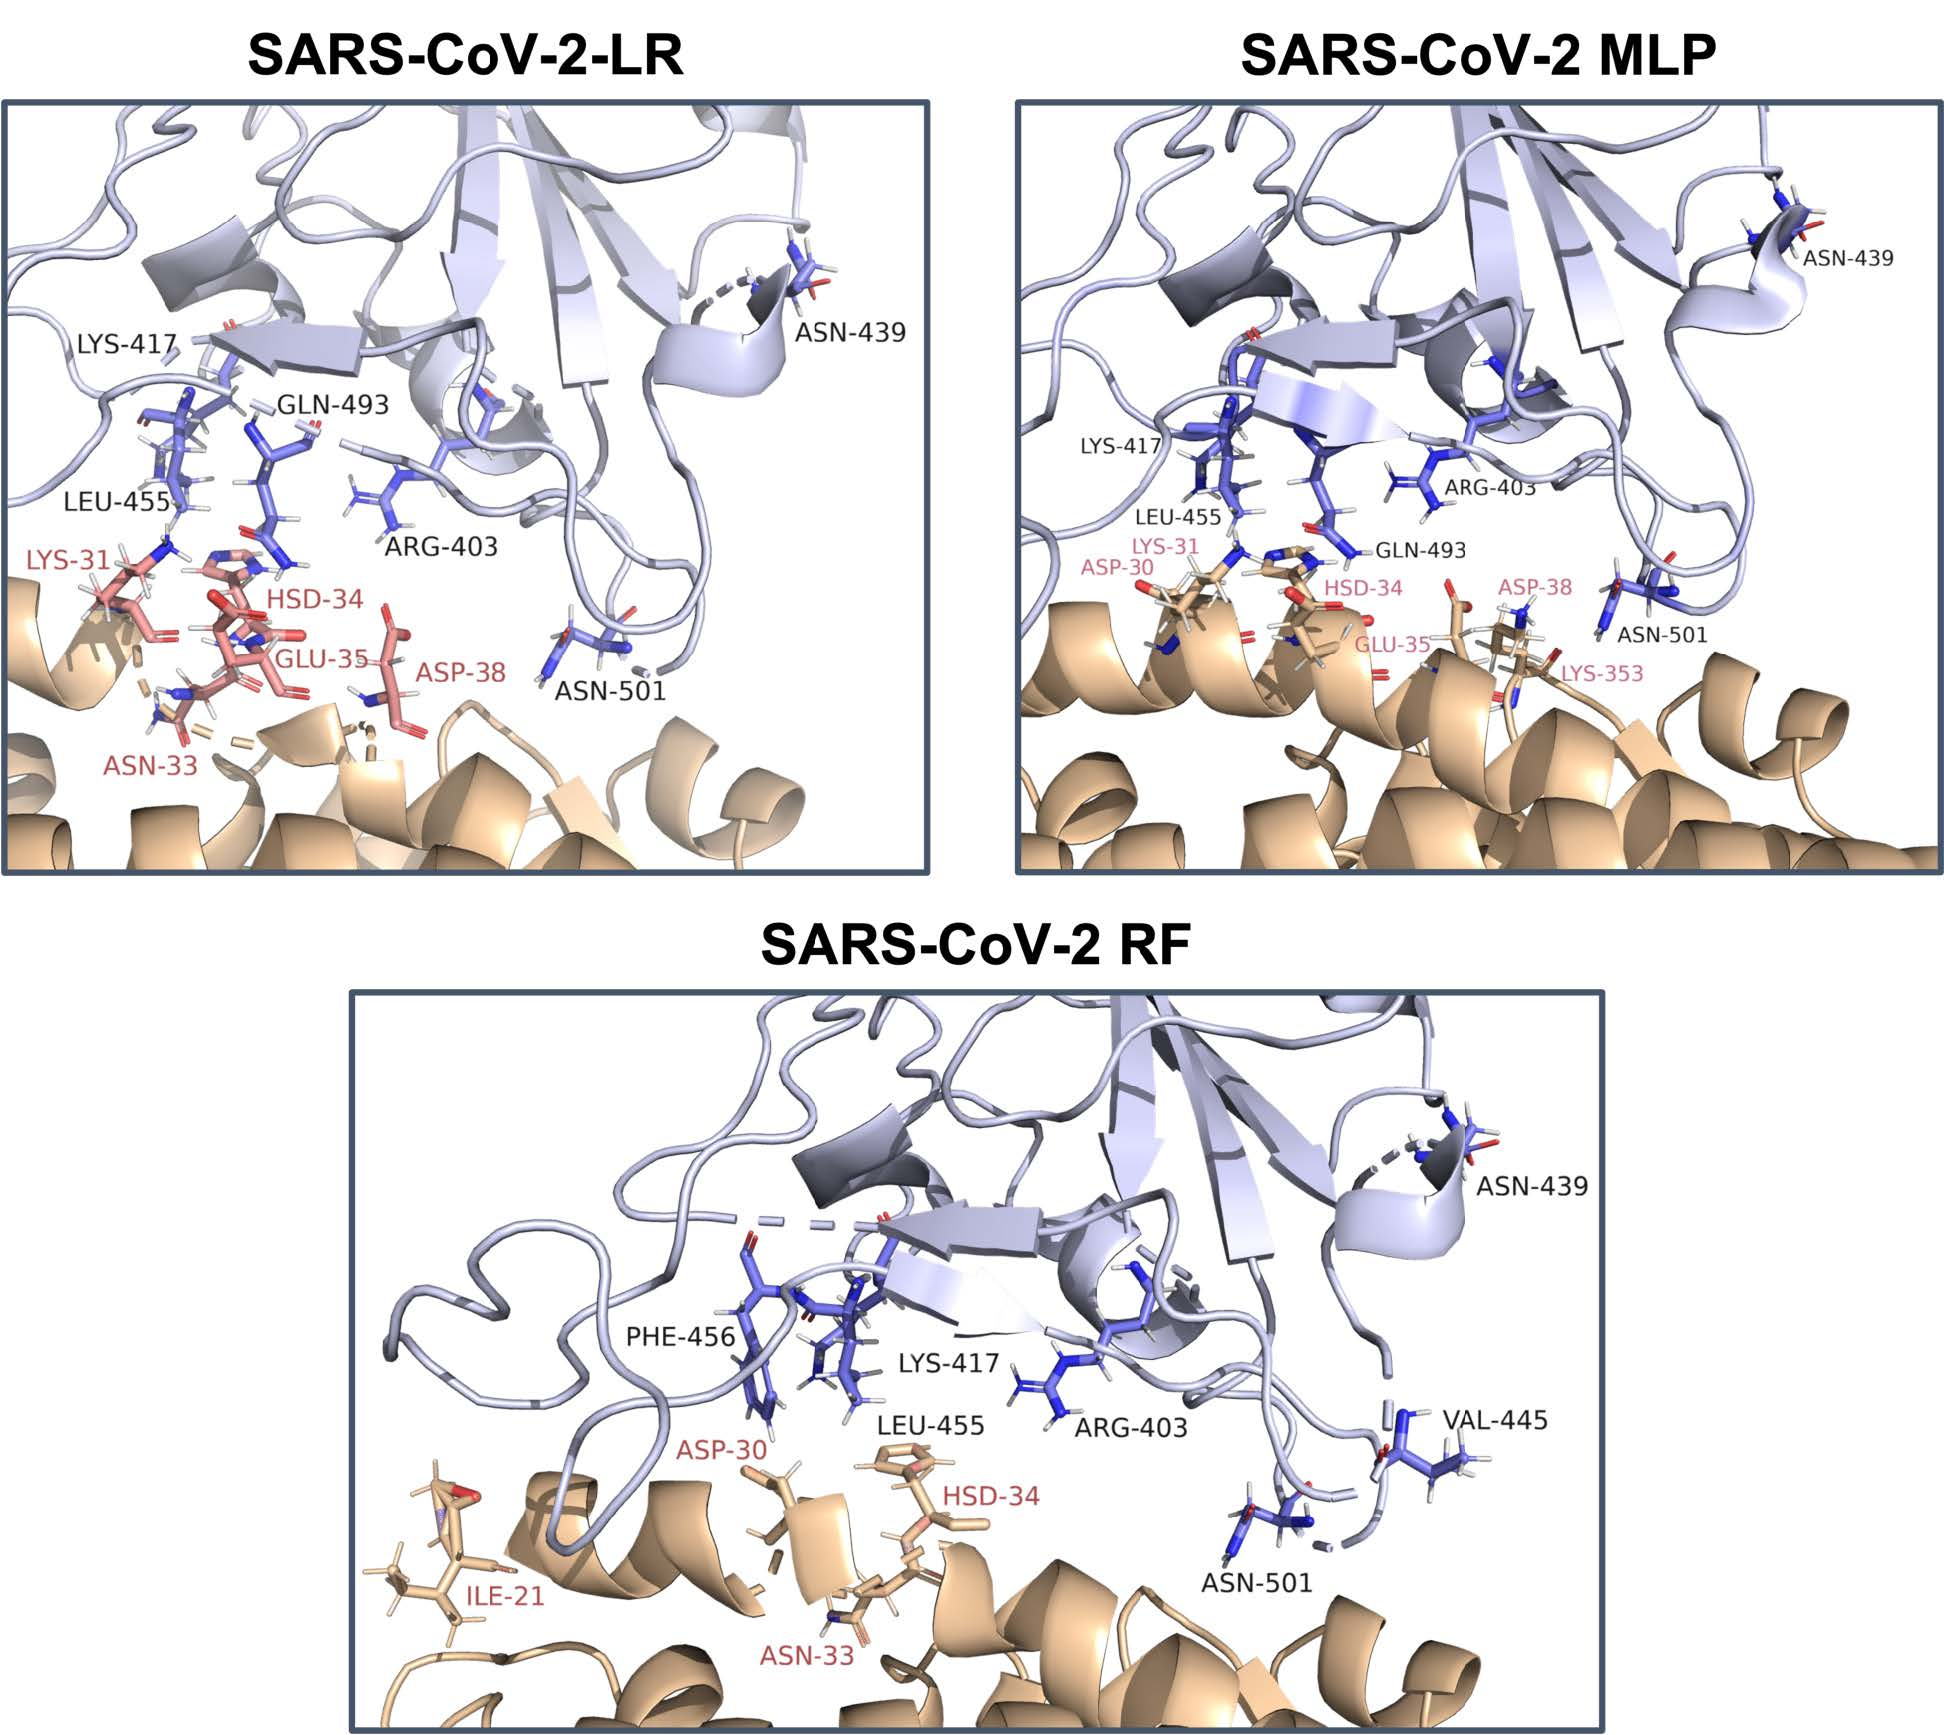
It’s not necessarily clear which method is ‘better’, but it is worthwhile to discuss the results and how they differ.

Compare your results to the literature results! Below is a figure from the original paper, mapping the importance of the residues back onto the protein structure.

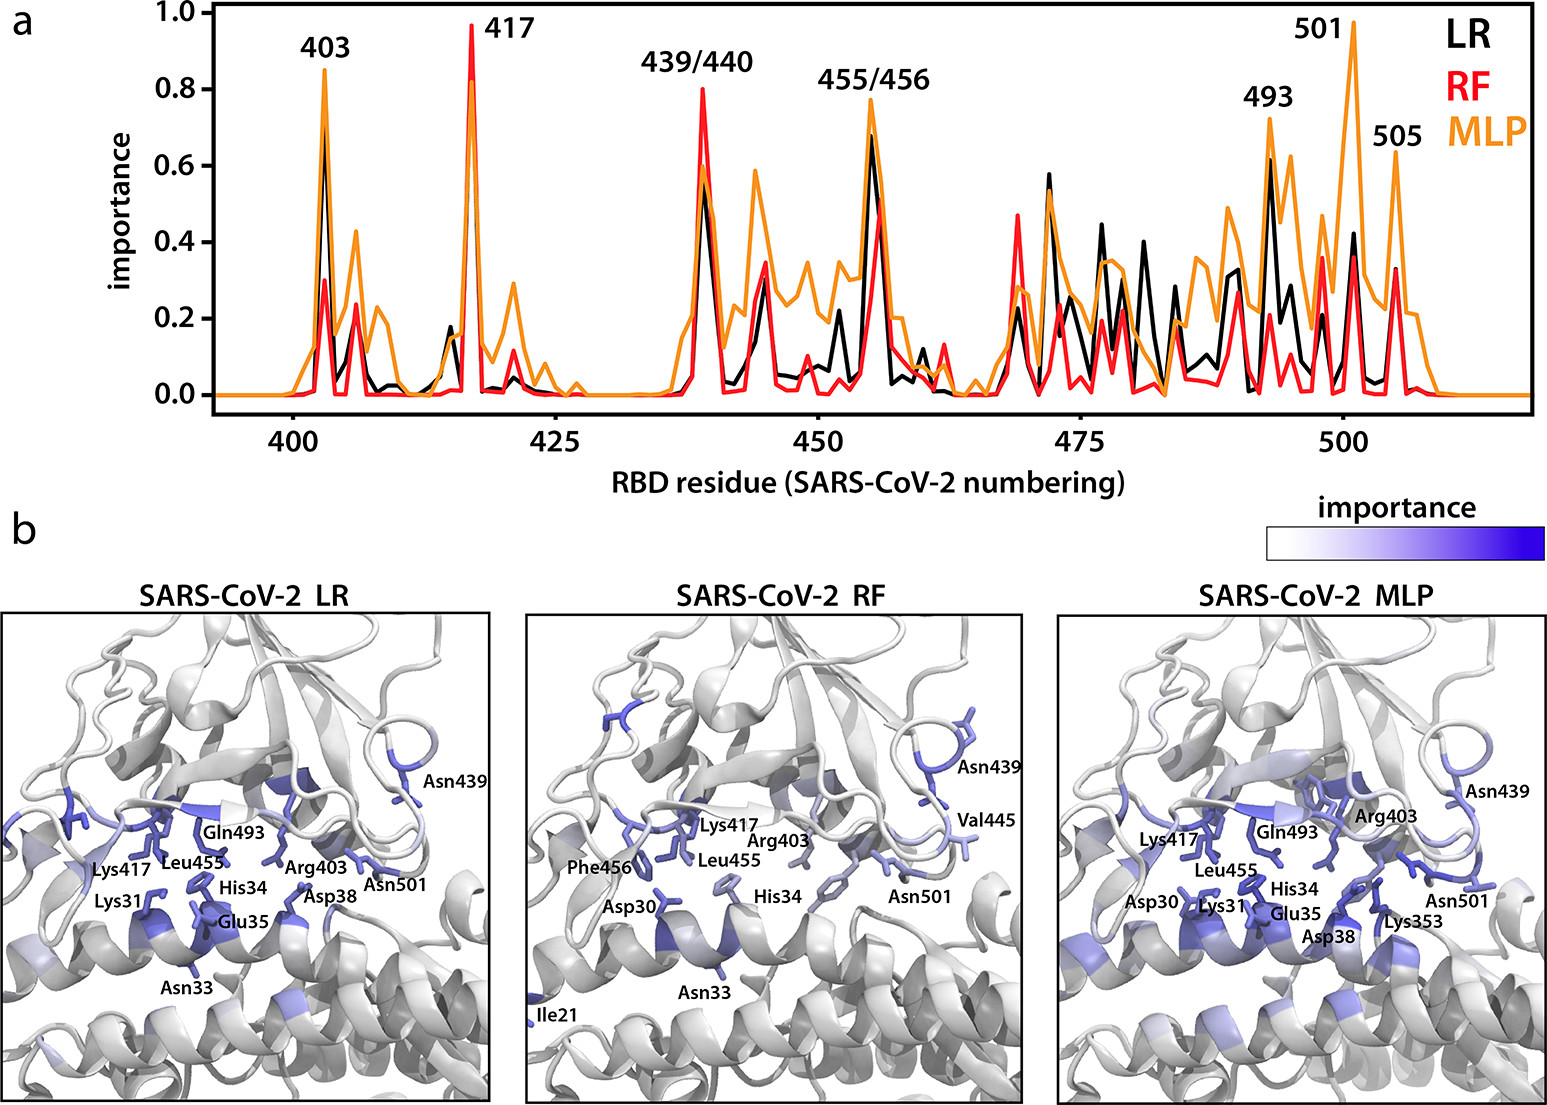

🔬🧪⚛️  How well do you understand applying ML methods to molecular dynamics trajectories? Test your knowledge below!

In [1]:
pip install jupyterquiz

Note: you may need to restart the kernel to use updated packages.


In [2]:
from IPython.display import IFrame
IFrame('quizzes/Quiz2.html', width=800, height=400)

# References
(1) Pavlova, A.; Zhang, Z.; Acharya, A.; Lynch, D. L.; Pang, Y. T.; Mou, Z.; Parks, J. M.; Chipot, C.;
Gumbart, J. C. Machine Learning Reveals the Critical Interactions for SARS-CoV-2 Spike Protein
Binding to ACE2. J. Phys. Chem. Lett. 2021, 12, 5494–5502, DOI: 10.1021/acs.jpclett.1c01494.
(2) Chan, J. Y.-L.; Leow, S. M. H.; Bea, K. T.; Cheng, W. K.; Phoong, S. W.; Hong, Z.-W.; Chen, Y.-L.
Mitigating the Multicollinearity Problem and Its Machine Learning Approach: A Review. Mathematics
2022, 10, 1283, DOI: 10.3390/math10081283.